# Retrieve Data

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

symbols = ['NVDA', 'TSLA', 'META', 'PLTR', 'KO', 'JNJ']
start_date = '2022-01-01'
end_date = '2025-07-31'

class YahooFinance:
    def __init__(self):
        pass
    
    def download_data(self, symbols:list[str], start_date:str, end_date:str, interval:str='1d') -> pd.DataFrame:
        prices = yf.download(symbols, start=start_date, end=end_date, interval=interval, auto_adjust=False)
        prices.index = prices.index.date
        return prices
    
    def get_pct_change(self, prices:pd.DataFrame, col_name:str='Adj Close', is_log:bool=True) -> pd.DataFrame:
        df = prices[col_name]
        if is_log:
            returns_df = np.log(df/ df.shift(1))
        else:
            returns_df = df.pct_change()
            
        returns_df = returns_df.dropna()
        return returns_df

yf_api = YahooFinance()
prices = yf_api.download_data(symbols, start_date, end_date)
df = yf_api.get_pct_change(prices)
df.head(2)

[*********************100%***********************]  6 of 6 completed


Ticker,JNJ,KO,META,NVDA,PLTR,TSLA
2022-01-04,-0.002685,0.016557,-0.005955,-0.027976,-0.019619,-0.042733
2022-01-05,0.006641,0.008259,-0.037419,-0.059285,-0.068914,-0.054954


# Price Change and Mu/Sigma

[*********************100%***********************]  7 of 7 completed


Comparison of normalised price changes from 2022-2025


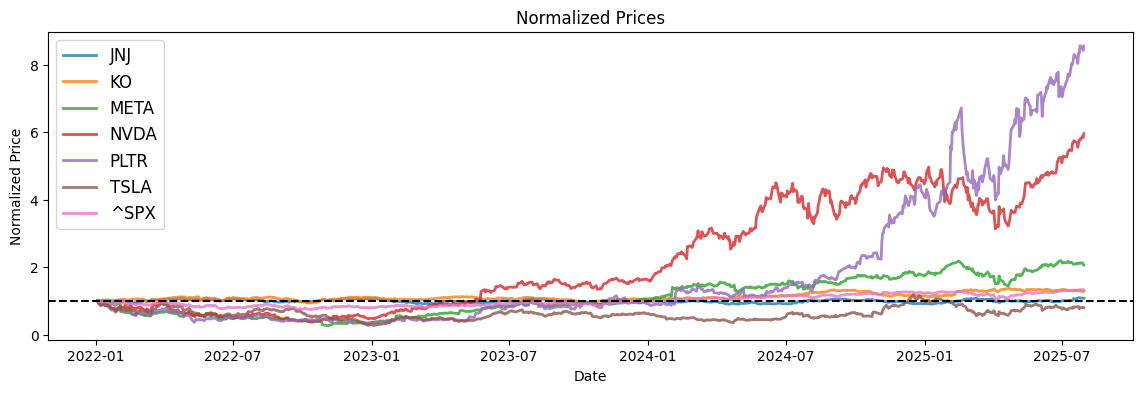

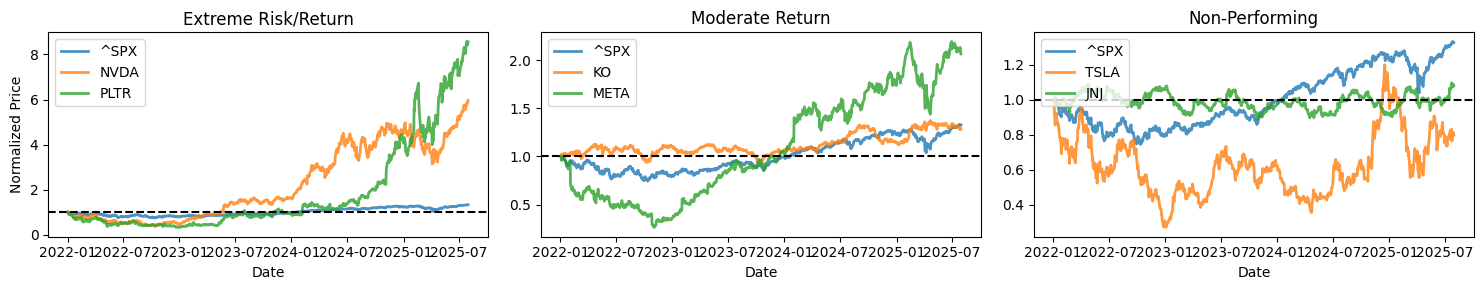

In [2]:
symbols2 = ['NVDA', 'TSLA', 'META', 'PLTR', 'JNJ', 'KO', '^SPX']
prices2 = yf_api.download_data(symbols2, start_date, end_date)
print("Comparison of normalised price changes from 2022-2025")

normalised_prices = prices2["Adj Close"] / prices2["Adj Close"].iloc[0]
high = normalised_prices[['^SPX', 'NVDA', 'PLTR']]
med = normalised_prices[['^SPX', 'KO', 'META']]
low = normalised_prices[['^SPX', 'TSLA', 'JNJ']]

types = [high, med, low]
titles = ["Extreme Risk/Return", "Moderate Return", "Non-Performing"]

plt.figure(figsize=(14, 4))
for c in normalised_prices.columns.values:
    plt.plot(normalised_prices.index, normalised_prices[c], lw=2, alpha=0.8, label=c)
plt.legend(loc='upper left', fontsize=12)
plt.title('Normalized Prices')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.axhline(y=1, color='black', linestyle='--')
plt.show()


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3), sharey=False)
for i, t in enumerate(types):
    ax = axes[i]
    for c in t.columns.values:
        ax.plot(normalised_prices.index, t[c], lw=2, alpha=0.8, label=c)
    ax.legend(loc='upper left', fontsize=10)
    ax.set_title(titles[i])
    ax.set_xlabel('Date')
    if i == 0:
        ax.set_ylabel('Normalized Price')
    ax.axhline(y=1, color='black', linestyle='--')

plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns

mu_daily, sigma_daily = df.mean(), df.cov()
mu = mu_daily * 252
sigma = sigma_daily * 252

print("----- Average Return (Mu) to 3d.p -----")
print(round(mu, 3))
plt.figure(figsize=(4, 2.5))
plt.bar(mu.index, mu)
plt.title("Annualised Return")
plt.show()

print("----- Covariance Matrix (Sigma) -----")
print(sigma)
plt.figure(figsize=(5, 3))
sns.heatmap(sigma, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Covariance Matrix')
plt.show()

# Performance Metrics

In [ ]:
from homework_1_helper import PerformanceMetrics
pm = PerformanceMetrics(df['META'])
metrics = pm.pipeline()
metrics

In [4]:
def get_weights_dataframe(self):
    """Create a DataFrame of weights aligned with rebalancing dates"""
    weights_df = pd.DataFrame(self.weights_history, columns=self.assets)
    # Align weights with portfolio return dates based on rebalancing frequency
    rebalance_dates = self.portfolio_returns.index[::self.rebalance_freq][:len(weights_df)]
    weights_df.index = rebalance_dates
    return weights_df

def plot_performance(self):
    """Create separate charts for performance and weights"""
    cumulative_returns = (1 + self.portfolio_returns).cumprod()
    weights_df = get_weights_dataframe(self)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # Portfolio performance chart
    ax1.plot(cumulative_returns.index, cumulative_returns.values, 
                color='navy', linewidth=2, label='Portfolio Value')
    ax1.set_ylabel('Cumulative Portfolio Value', fontsize=12)
    ax1.set_title('Portfolio Performance Over Time', fontsize=13)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Asset weights chart
    colors = plt.cm.Set3(np.linspace(0, 1, len(self.assets)))
    ax2.stackplot(weights_df.index, weights_df.T, labels=self.assets, 
                    alpha=0.8, colors=colors)
    ax2.set_ylabel('Asset Weights', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_title('Asset Weight Distribution Over Time', fontsize=13)
    ax2.set_ylim(0, 1)
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    plt.show()

# 1. Global Minimum Variance Portfolio (GMVP)

Max Sharpe Portfolio Out-of-Sample Performance:
CAGR:            0.0721
Annual Volatility:0.1224
Sharpe Ratio:    0.5894
Max Drawdown:    -0.1425


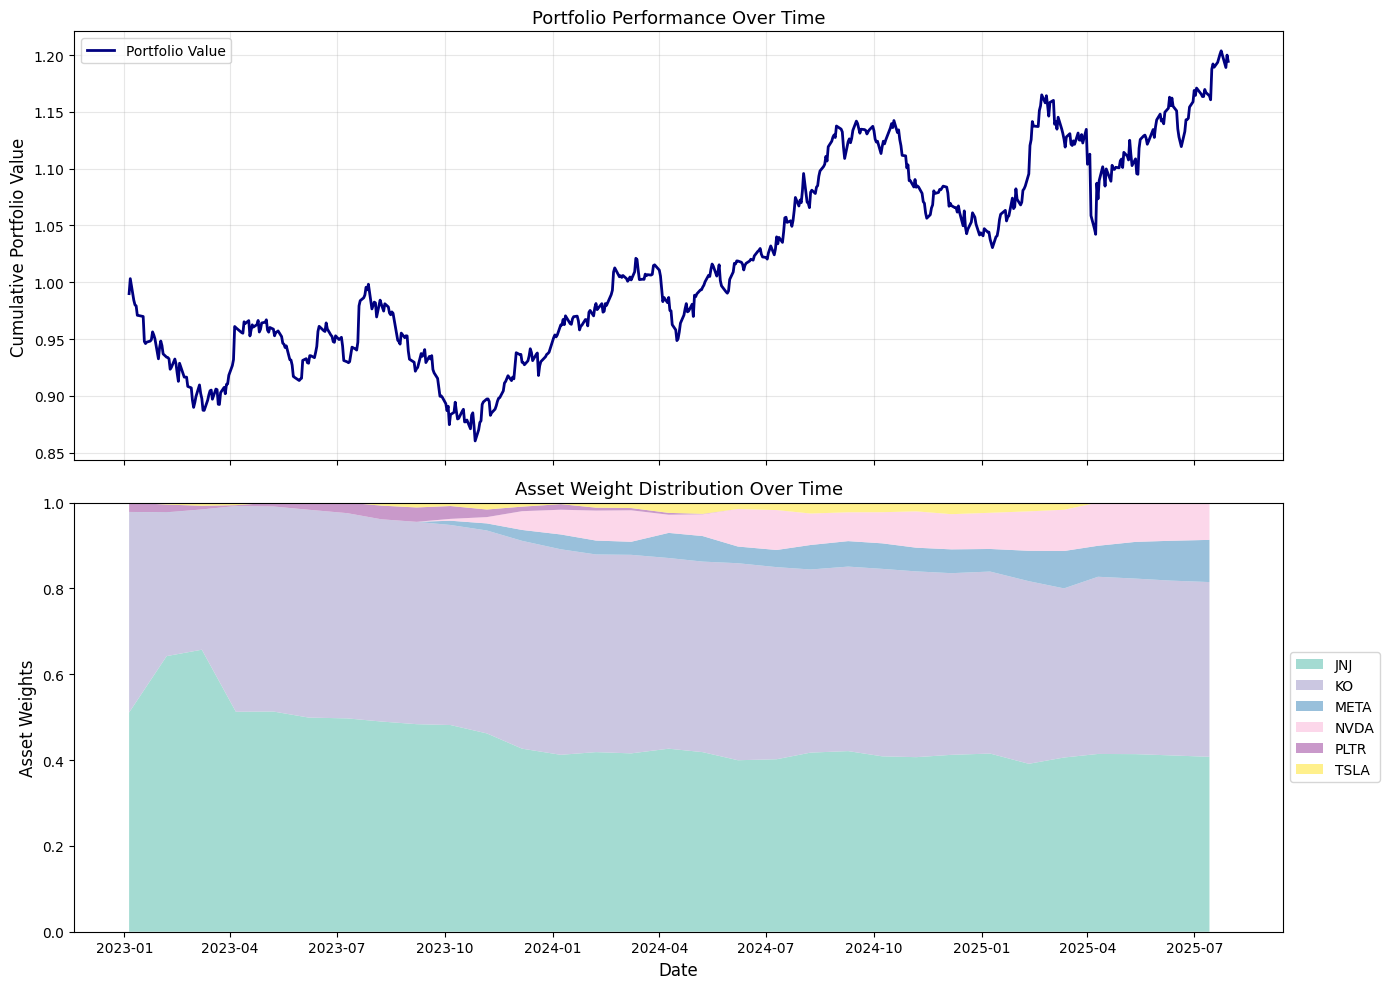

In [6]:
from homework_1_helper import Gmvp

gmvp = Gmvp(df)
gmvp.run_rolling_optimisation()
min_variance_metrics = gmvp.report_performance()
plot_performance(gmvp)

# 2. Max Sharpe Ratio Portfolio

Max Sharpe Portfolio Out-of-Sample Performance:
CAGR:            0.6507
Annual Volatility:0.2974
Sharpe Ratio:    2.1882
Max Drawdown:    -0.1681


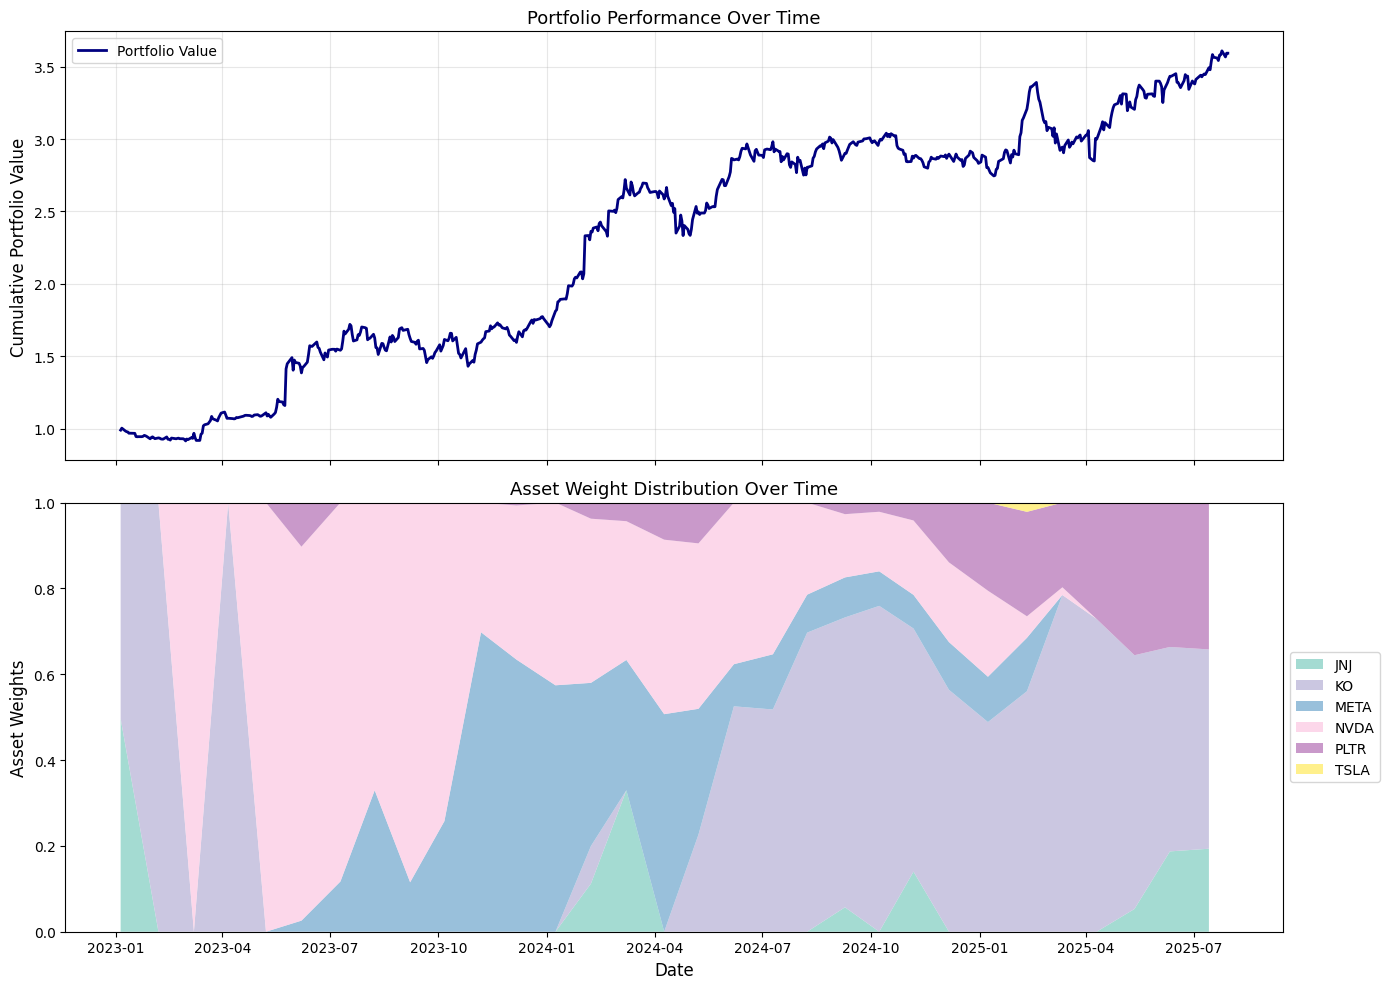

In [7]:
from homework_1_helper import MaxSharpePortfolio

max_sharpe = MaxSharpePortfolio(df)
max_sharpe.run_rolling_optimization()
max_sharpe_metrics = max_sharpe.report_performance()
plot_performance(max_sharpe)

# 3. Maximum Return Portfolio

Max Sharpe Portfolio Out-of-Sample Performance:
CAGR:            1.6701
Annual Volatility:0.5486
Sharpe Ratio:    3.0441
Max Drawdown:    -0.4061


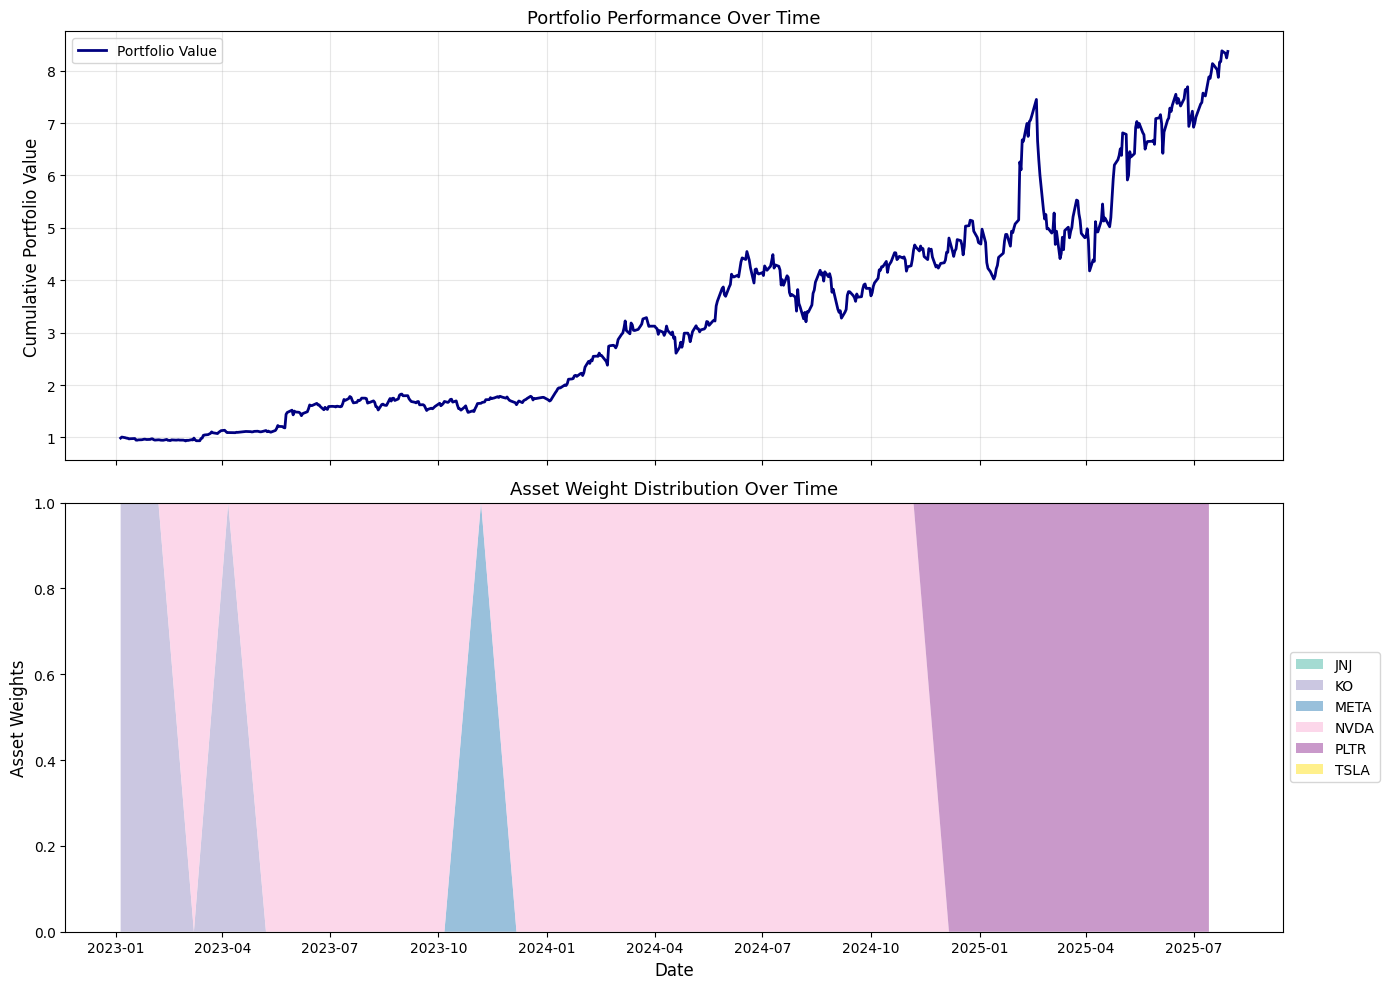

In [8]:
from homework_1_helper import MaximumReturn
mr = MaximumReturn(df)
mr.run_rolling_optimization()
max_return_metrics = mr.report_performance()
plot_performance(mr)

# Comparing the Performance of each Portfolio

In [14]:
results_df = pd.DataFrame([min_variance_metrics, max_sharpe_metrics, max_return_metrics], index=["min variance", "max sharpe ratio", "max returns"])
results_df

,cagr,annualized_vol,sharpe_ratio,max_draw_down
min variance,0.072142,0.122402,0.589389,-0.142476
max sharpe ratio,0.650740,0.297391,2.188162,-0.168135
max returns,1.670084,0.548636,3.044064,-0.406115


### We observe a few interesting results
\#1.  Min Variance performs quite badly, despite what the literature may suggest, but is likely due to the inadequacy of choices of stocks to pick from, as the low volatility stocks also did not have high return.

\#2. Max Sharpe ratio did not have the highest sharpe ratio, but is understandable since Max Returns just benefitted from the supernormal returns from NVDA/PLTR, and we can see how this is penalised by the 40% Max Drawdown from the Max Returns strategy.